In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import os

sns.set_style('whitegrid')

## Police forces included with dataset after processing
https://www.statista.com/statistics/877540/leading-police-forces-by-officer-numbers-in-the-uk/#:~:text=London's%20Metropolitan%20Police%20is%20by,Northern%20Ireland%20at%206.9%20thousand.


All,
Avon and Somerset,
Bedfordshire,
Cambridgeshire,
Cheshire,
Cleveland,
Cumbria,
Derbyshire,
Devon and Cornwall,
Dorset,
Durham,
Dyfed-Powys,
Essex,
Gloucestershire,
Greater Manchester,
Gwent,
Hampshire,
Hertfordshire,
Humberside,
Kent,
Lancashire,
Leicestershire,
Lincolnshire,
London, City of,
Merseyside,
Metropolitan Police,
Norfolk,
North Wales,
North Yorkshire,
Northamptonshire,
Northumbria,
Nottinghamshire,
South Wales,
South Yorkshire,
Staffordshire,
Suffolk,
Surrey,
Sussex,
Thames Valley,
Warwickshire,
West Mercia,
West Midlands,
West Yorkshire,
Wiltshire


In [2]:
arrest_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/crime-justice-and-the-law/policing/number-of-arrests/latest/downloads/number-of-arrests.csv').content
arrest_df = pd.read_csv(io.StringIO(arrest_data.decode('utf-8')))
arrest_df = arrest_df.drop(columns=['Notes'])
arrest_df = arrest_df.dropna()
arrest_df = arrest_df[arrest_df['Age_Group'] == 'All']
arrest_df = arrest_df[arrest_df['Gender'] == 'All']
arrest_df.shape

(12144, 15)

In [3]:
def get_arrest_per_pop(location, df):
  df_new = df[df['Geography'] == location]
  df_new = df_new[df_new['Rate per 1,000 population by ethnicity, gender, and PFA'] != ' N/A ']
  df_new = df_new.pivot(index='Time', columns='Ethnicity' ,values='Rate per 1,000 population by ethnicity, gender, and PFA')
  # Used when working with total value of arrests to remove commas from values above 1,000 (changes 1,000 (str) to 1000 (int))
  # df_new = df_new.convert_dtypes()
  # df_new = df_new.apply(lambda x: x.str.replace(',', ''))
  df_new = df_new.apply(lambda x: x.str.replace('-','0'))
  df_new = df_new.fillna(0) #Set NA values to 0 - we are assuming there was no recorded arrests of that ethnicity in that year. Mean could be used but that would does not seem like a valid identifier
  df_new = df_new.astype(int)

  df_new['Black'] = df_new['Black'] + df_new['Black African'] + df_new['Black Caribbean'] + df_new['Any other black background']
  df_new['Black'] = df_new['Black']/4
  df_new['White'] = df_new['White'] + df_new['White British'] + df_new['White Irish'] + df_new['Any other white background']
  df_new['White'] = df_new['White']/4
  df_new['Asian'] = df_new['Asian'] + df_new['Chinese'] + df_new['Indian'] + df_new['Bangladeshi'] + df_new['Pakistani'] + df_new['Any other asian']
  df_new['Asian'] = df_new['Asian']/6
  df_new['Mixed'] = df_new['Mixed'] + df_new['Mixed White and Asian'] + df_new['Mixed White and Black African'] + df_new['Mixed White and Black Caribbean'] + df_new['Any other mixed/multiple ethnic background']
  df_new['Mixed'] = df_new['Mixed']/5
  df_new['Other'] = df_new['Other'] + df_new['Any other ethnic group']
  df_new['Other'] = df_new['Other']/2
  df_new['All'] = (df_new['Black'] + df_new['White'] + df_new['Asian'] + df_new['Mixed'] + df_new['Other'])/5
  df_new = df_new.drop(columns=['Black African', 'Black Caribbean', 'Any other black background', 'White British', 'White Irish', 'Any other white background', 'Chinese', 'Indian', 'Bangladeshi', 'Pakistani', 'Any other asian', 'Mixed White and Asian', 'Mixed White and Black African', 'Mixed White and Black Caribbean', 'Any other mixed/multiple ethnic background', 'Any other ethnic group'])

  return df_new

In [4]:
arrest_df_all = get_arrest_per_pop('All', arrest_df)
#Large forces
arrest_df_manchester = get_arrest_per_pop('Greater Manchester', arrest_df)
arrest_df_london = get_arrest_per_pop('Metropolitan Police', arrest_df)
#Medium forces
arrest_df_essex = get_arrest_per_pop('Essex', arrest_df)
arrest_df_lancashire = get_arrest_per_pop('Lancashire', arrest_df)
#Small forces
arrest_df_suffolk = get_arrest_per_pop('Suffolk', arrest_df)
arrest_df_wiltshire = get_arrest_per_pop('Wiltshire', arrest_df)

In [5]:
arrest_df_all

Ethnicity,All,Asian,Black,Mixed,Other,White
Time,,,,,,
2006/07,31.376667,17.333333,60.00,31.8,24.0,23.75
2007/08,33.060000,19.000000,62.75,31.8,26.0,25.75
2008/09,33.770000,20.000000,65.00,31.6,25.5,26.75
2009/10,33.503333,19.666667,65.25,31.6,24.5,26.50
2010/11,33.706667,19.833333,66.75,32.2,24.0,25.75
2011/12,30.876667,17.833333,61.00,29.8,22.0,23.75
2012/13,27.226667,15.833333,52.75,25.8,20.0,21.75
2013/14,26.436667,15.833333,51.75,24.6,19.0,21.00
2014/15,24.833333,14.666667,49.75,23.0,18.0,18.75


Text(0.5, 1.0, 'Total arrests')

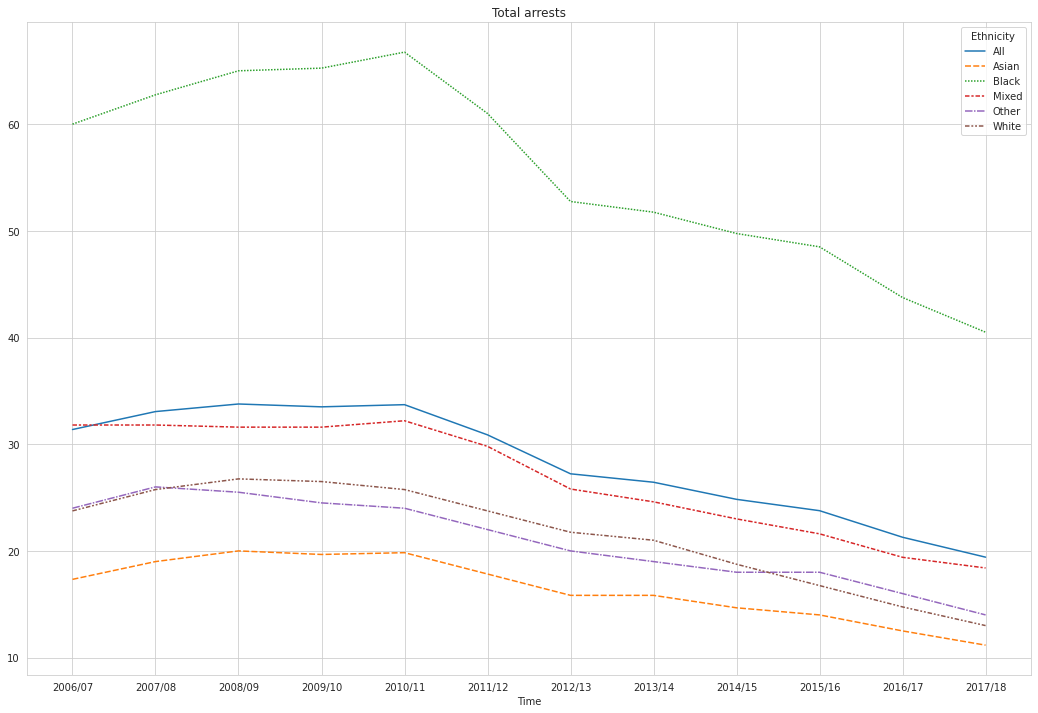

In [6]:
fig, ax = plt.subplots(figsize=(18,12), sharey='all')
sns.lineplot(data=arrest_df_all)
ax.set_title('Total arrests')

Text(0.5, 1.0, 'Wiltshire Arrests')

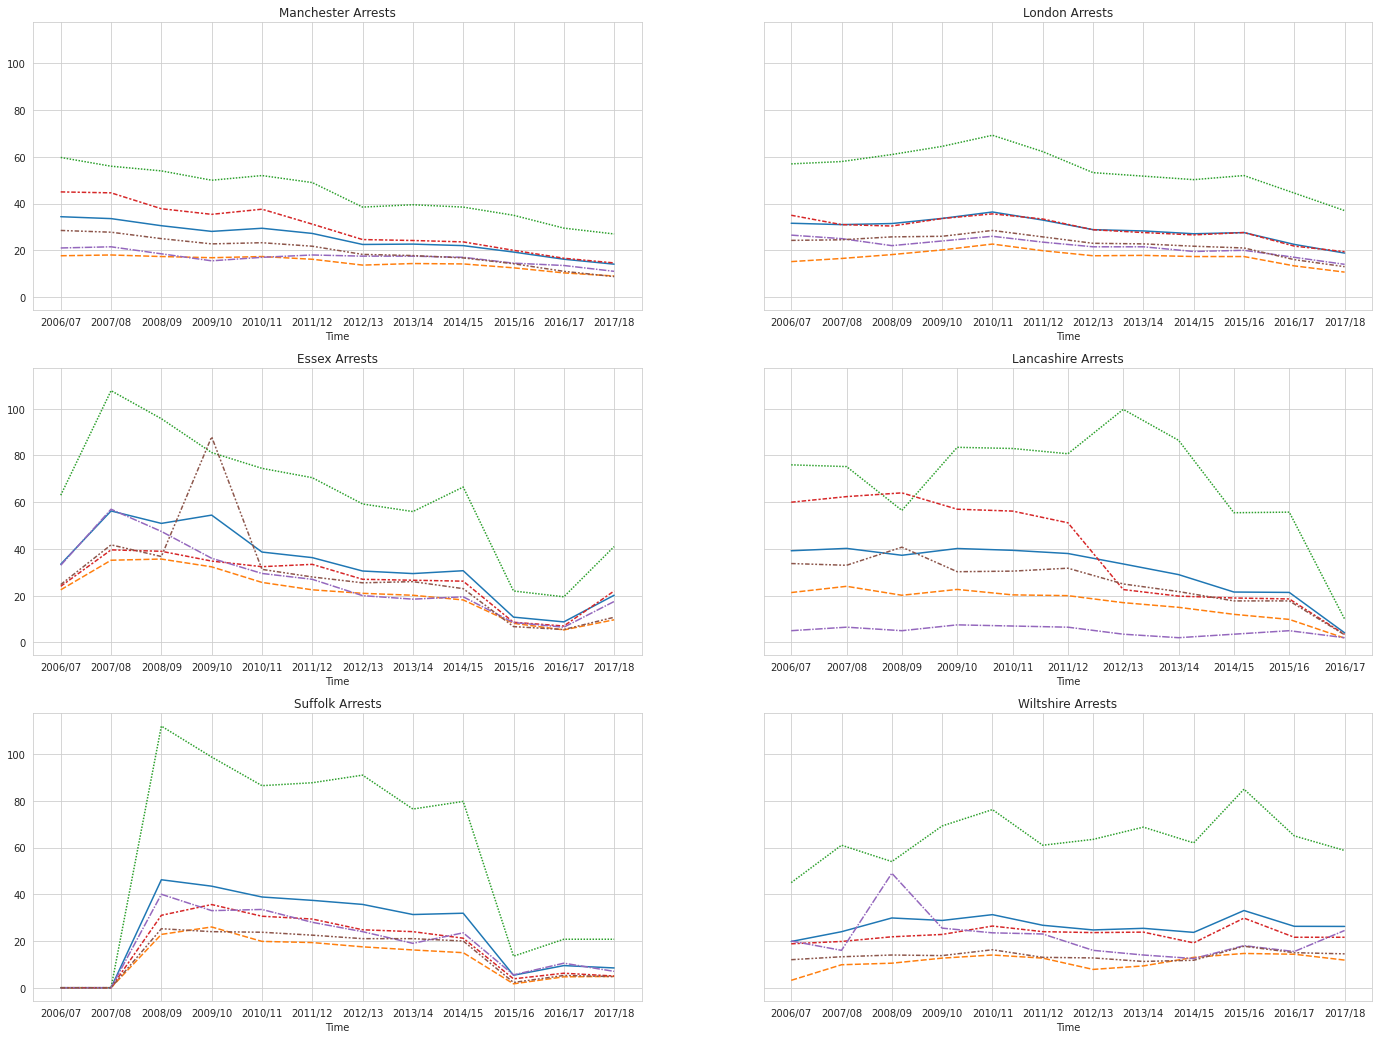

In [7]:
fig, ax = plt.subplots(3,2, figsize=(24,18), sharey='all')
sns.lineplot(data=arrest_df_manchester, ax=ax[0,0], legend=False)
sns.lineplot(data=arrest_df_london, ax=ax[0,1], legend=False)
sns.lineplot(data=arrest_df_essex, ax=ax[1,0], legend=False)
sns.lineplot(data=arrest_df_lancashire, ax=ax[1,1], legend=False)
sns.lineplot(data=arrest_df_suffolk, ax=ax[2,0], legend=False)
sns.lineplot(data=arrest_df_wiltshire, ax=ax[2,1], legend=False)
ax[0,0].set_title('Manchester Arrests')
ax[0,1].set_title('London Arrests')
ax[1,0].set_title('Essex Arrests')
ax[1,1].set_title('Lancashire Arrests')
ax[2,0].set_title('Suffolk Arrests')
ax[2,1].set_title('Wiltshire Arrests')


## Add Ethnicity of Officers to data

In [236]:
officer_data = requests.get('https://www.ethnicity-facts-figures.service.gov.uk/workforce-and-business/workforce-diversity/police-workforce/latest/downloads/by-ethnicity-over-time-police-officers.csv').content
officer_data = pd.read_csv(io.StringIO(arrest_data.decode('utf-8')))

In [237]:
officer_data = officer_data.pivot(index='Time', columns='Ethnicity', values='Number of police officers (FTE) ')

In [238]:
officer_data = officer_data.drop(columns=['Unknown'])

In [261]:
officer_data = officer_data.rename(columns={'Other inc Chinese': 'Other Officers', 'Time': 'Date',
                                            'White': 'White Officers',
                                            'Black': 'Black Officers',
                                            'Asian': 'Asian Officers',
                                            'Mixed': 'Mixed Officers'})

In [262]:
officer_data = reload_del_index(officer_data).iloc[0:12]

In [263]:
arrest_df_all_re = reload(arrest_df_all)

In [264]:
data_all = pd.concat([arrest_df_all_re, officer_data], axis=1)

In [265]:
data_all

,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,2006/07,31.376667,17.333333,60.00,31.8,24.0,23.75,"2,111","1,350","1,419",632,"134,372"
1,2007/08,33.060000,19.000000,62.75,31.8,26.0,25.75,"2,231","1,371","1,525",656,"134,000"
2,2008/09,33.770000,20.000000,65.00,31.6,25.5,26.75,"2,472","1,427","1,699",689,"135,651"
3,2009/10,33.503333,19.666667,65.25,31.6,24.5,26.50,"2,607","1,446","1,844",745,"135,293"
4,2010/11,33.706667,19.833333,66.75,32.2,24.0,25.75,"2,582","1,442","1,838",754,"130,870"
5,2011/12,30.876667,17.833333,61.00,29.8,22.0,23.75,"2,607","1,420","1,871",766,"125,579"
6,2012/13,27.226667,15.833333,52.75,25.8,20.0,21.75,"2,563","1,361","1,865",749,"121,086"
7,2013/14,26.436667,15.833333,51.75,24.6,19.0,21.00,"2,665","1,352","1,922",776,"119,071"
8,2014/15,24.833333,14.666667,49.75,23.0,18.0,18.75,"2,795","1,373","2,028",785,"117,757"
9,2015/16,23.770000,14.000000,48.50,21.6,18.0,16.75,"2,881","1,433","2,096",808,"114,437"


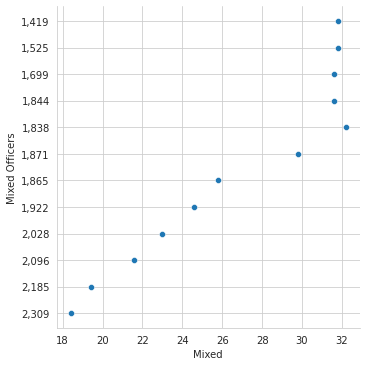

In [271]:
sns.relplot(x='Mixed', y='Mixed Officers', data=data_all)

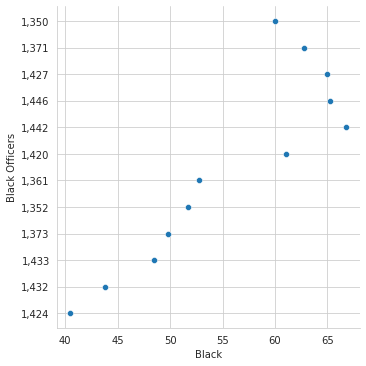

In [267]:
sns.relplot(x='Black', y='Black Officers', data=data_all)

More officers = less  arrests

correllation or casue?



## Save data

In [62]:
!mkdir temp

In [161]:
def reload(df):
  if os.path.exists('temp/df.csv'):
    os.remove('temp/df.csv')
  df.to_csv('temp/df.csv')
  return(pd.read_csv('/content/temp/df.csv'))

In [148]:
def reload_del_index(df):
  if os.path.exists('temp/df.csv'):
    os.remove('temp/df.csv')
  df.to_csv('temp/df.csv', index=False)
  return(pd.read_csv('/content/temp/df.csv'))

In [17]:
!mkdir data

In [272]:
arrest_df_all.to_csv('data/arrest_all.csv')
arrest_df_manchester.to_csv('data/arrest_manchester.csv')
arrest_df_london.to_csv('data/arrest_london.csv')
arrest_df_essex.to_csv('data/arrest_essex.csv')
arrest_df_lancashire.to_csv('data/arrest_lancashire.csv')
arrest_df_suffolk.to_csv('data/arrest_suffolk.csv')
arrest_df_wiltshire.to_csv('data/arrest_wiltshire.csv')
data_all.to_csv('data/data_all.csv')

In [273]:
!zip -r /content/data.zip /content/data/

updating: content/data/ (stored 0%)
updating: content/data/arrest_london.csv (deflated 61%)
updating: content/data/arrest_all.csv (deflated 60%)
updating: content/data/arrest_essex.csv (deflated 58%)
updating: content/data/arrest_manchester.csv (deflated 59%)
updating: content/data/arrest_lancashire.csv (deflated 54%)
updating: content/data/arrest_suffolk.csv (deflated 58%)
updating: content/data/arrest_wiltshire.csv (deflated 59%)
  adding: content/data/data_all.csv (deflated 57%)
